In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
import numpy as np
import requests
import os
import zipfile
from tqdm import tqdm
import alignn
from alignn.models.alignn import ALIGNN, ALIGNNConfig
from alignn.data import get_torch_dataset
from torch.utils.data import DataLoader
import tempfile
import torch
import sys

# from jarvis.db.jsonutils import loadjson
import argparse
from jarvis.core.atoms import Atoms
from jarvis.core.graphs import Graph
from jarvis.db.jsonutils import dumpjson
import pandas as pd
import json

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
"""Shared pydantic settings configuration."""
import json
from pathlib import Path
from typing import Union
import matplotlib.pyplot as plt

from pydantic import BaseSettings as PydanticBaseSettings


class BaseSettings(PydanticBaseSettings):
    """Add configuration to default Pydantic BaseSettings."""

    class Config:
        """Configure BaseSettings behavior."""

        extra = "forbid"
        use_enum_values = True
        env_prefix = "jv_"


def plot_learning_curve(
    results_dir: Union[str, Path], key: str = "mae", plot_train: bool = False
):
    """Plot learning curves based on json history files."""
    if isinstance(results_dir, str):
        results_dir = Path(results_dir)

    with open(results_dir / "history_val.json", "r") as f:
        val = json.load(f)

    p = plt.plot(val[key], label=results_dir.name)

    if plot_train:
        # plot the training trace in the same color, lower opacity
        with open(results_dir / "history_train.json", "r") as f:
            train = json.load(f)

        c = p[0].get_color()
        plt.plot(train[key], alpha=0.5, c=c)

    plt.xlabel("epochs")
    plt.ylabel(key)

    return train, val

"""Shared model-building components."""
from typing import Optional

import numpy as np
import torch
from torch import nn


class RBFExpansion(nn.Module):
    """Expand interatomic distances with radial basis functions."""

    def __init__(
        self,
        vmin: float = 0,
        vmax: float = 8,
        bins: int = 40,
        lengthscale: Optional[float] = None,
    ):
        """Register torch parameters for RBF expansion."""
        super().__init__()
        self.vmin = vmin
        self.vmax = vmax
        self.bins = bins
        self.register_buffer(
            "centers", torch.linspace(self.vmin, self.vmax, self.bins)
        )

        if lengthscale is None:
            # SchNet-style
            # set lengthscales relative to granularity of RBF expansion
            self.lengthscale = np.diff(self.centers).mean()
            self.gamma = 1 / self.lengthscale

        else:
            self.lengthscale = lengthscale
            self.gamma = 1 / (lengthscale ** 2)

    def forward(self, distance: torch.Tensor) -> torch.Tensor:
        """Apply RBF expansion to interatomic distance tensor."""
        return torch.exp(
            -self.gamma * (distance.unsqueeze(1) - self.centers) ** 2
        )

"""Atomistic LIne Graph Neural Network.

A prototype crystal line graph network dgl implementation.
"""
from typing import Tuple, Union

import dgl
import dgl.function as fn
import numpy as np
import torch
from dgl.nn import AvgPooling

# from dgl.nn.functional import edge_softmax
from pydantic.typing import Literal
from torch import nn
from torch.nn import functional as F

#from alignn.models.utils import RBFExpansion
#from alignn.utils import BaseSettings


class ALIGNNConfig(BaseSettings):
    """Hyperparameter schema for jarvisdgl.models.alignn."""

    name: Literal["alignn"]
    alignn_layers: int = 4
    gcn_layers: int = 4
    atom_input_features: int = 92
    edge_input_features: int = 80
    triplet_input_features: int = 40
    embedding_features: int = 64
    hidden_features: int = 256
    # fc_layers: int = 1
    # fc_features: int = 64
    output_features: int = 1

    # if link == log, apply `exp` to final outputs
    # to constrain predictions to be positive
    link: Literal["identity", "log", "logit"] = "identity"
    zero_inflated: bool = False
    classification: bool = False
    num_classes: int = 2

    class Config:
        """Configure model settings behavior."""

        env_prefix = "jv_model"


class EdgeGatedGraphConv(nn.Module):
    """Edge gated graph convolution from arxiv:1711.07553.

    see also arxiv:2003.0098.

    This is similar to CGCNN, but edge features only go into
    the soft attention / edge gating function, and the primary
    node update function is W cat(u, v) + b
    """

    def __init__(
        self, input_features: int, output_features: int, residual: bool = True
    ):
        """Initialize parameters for ALIGNN update."""
        super().__init__()
        self.residual = residual
        # CGCNN-Conv operates on augmented edge features
        # z_ij = cat(v_i, v_j, u_ij)
        # m_ij = σ(z_ij W_f + b_f) ⊙ g_s(z_ij W_s + b_s)
        # coalesce parameters for W_f and W_s
        # but -- split them up along feature dimension
        self.src_gate = nn.Linear(input_features, output_features)
        self.dst_gate = nn.Linear(input_features, output_features)
        self.edge_gate = nn.Linear(input_features, output_features)
        self.bn_edges = nn.BatchNorm1d(output_features)

        self.src_update = nn.Linear(input_features, output_features)
        self.dst_update = nn.Linear(input_features, output_features)
        self.bn_nodes = nn.BatchNorm1d(output_features)

    def forward(
        self,
        g: dgl.DGLGraph,
        node_feats: torch.Tensor,
        edge_feats: torch.Tensor,
    ) -> torch.Tensor:
        """Edge-gated graph convolution.

        h_i^l+1 = ReLU(U h_i + sum_{j->i} eta_{ij} ⊙ V h_j)
        """
        g = g.local_var()

        # instead of concatenating (u || v || e) and applying one weight matrix
        # split the weight matrix into three, apply, then sum
        # see https://docs.dgl.ai/guide/message-efficient.html
        # but split them on feature dimensions to update u, v, e separately
        # m = BatchNorm(Linear(cat(u, v, e)))

        # compute edge updates, equivalent to:
        # Softplus(Linear(u || v || e))
        g.ndata["e_src"] = self.src_gate(node_feats)
        g.ndata["e_dst"] = self.dst_gate(node_feats)
        g.apply_edges(fn.u_add_v("e_src", "e_dst", "e_nodes"))
        m = g.edata.pop("e_nodes") + self.edge_gate(edge_feats)

        g.edata["sigma"] = torch.sigmoid(m)
        g.ndata["Bh"] = self.dst_update(node_feats)
        g.update_all(
            fn.u_mul_e("Bh", "sigma", "m"), fn.sum("m", "sum_sigma_h")
        )
        g.update_all(fn.copy_e("sigma", "m"), fn.sum("m", "sum_sigma"))
        g.ndata["h"] = g.ndata["sum_sigma_h"] / (g.ndata["sum_sigma"] + 1e-6)
        x = self.src_update(node_feats) + g.ndata.pop("h")

        # softmax version seems to perform slightly worse
        # that the sigmoid-gated version
        # compute node updates
        # Linear(u) + edge_gates ⊙ Linear(v)
        # g.edata["gate"] = edge_softmax(g, y)
        # g.ndata["h_dst"] = self.dst_update(node_feats)
        # g.update_all(fn.u_mul_e("h_dst", "gate", "m"), fn.sum("m", "h"))
        # x = self.src_update(node_feats) + g.ndata.pop("h")

        # node and edge updates
        x = F.silu(self.bn_nodes(x))
        y = F.silu(self.bn_edges(m))

        if self.residual:
            x = node_feats + x
            y = edge_feats + y

        return x, y


class ALIGNNConv(nn.Module):
    """Line graph update."""

    def __init__(
        self, in_features: int, out_features: int,
    ):
        """Set up ALIGNN parameters."""
        super().__init__()
        self.node_update = EdgeGatedGraphConv(in_features, out_features)
        self.edge_update = EdgeGatedGraphConv(out_features, out_features)

    def forward(
        self,
        g: dgl.DGLGraph,
        lg: dgl.DGLGraph,
        x: torch.Tensor,
        y: torch.Tensor,
        z: torch.Tensor,
    ):
        """Node and Edge updates for ALIGNN layer.

        x: node input features
        y: edge input features
        z: edge pair input features
        """
        g = g.local_var()
        lg = lg.local_var()
        # Edge-gated graph convolution update on crystal graph
        x, m = self.node_update(g, x, y)

        # Edge-gated graph convolution update on crystal graph
        y, z = self.edge_update(lg, m, z)

        return x, y, z


class MLPLayer(nn.Module):
    """Multilayer perceptron layer helper."""

    def __init__(self, in_features: int, out_features: int):
        """Linear, Batchnorm, SiLU layer."""
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.SiLU(),
        )

    def forward(self, x):
        """Linear, Batchnorm, silu layer."""
        return self.layer(x)


class ALIGNN(nn.Module):
    """Atomistic Line graph network.

    Chain alternating gated graph convolution updates on crystal graph
    and atomistic line graph.
    """

    def __init__(self, config: ALIGNNConfig = ALIGNNConfig(name="alignn")):
        """Initialize class with number of input features, conv layers."""
        super().__init__()
        # print(config)
        self.classification = config.classification

        self.atom_embedding = MLPLayer(
            config.atom_input_features, config.hidden_features
        )

        self.edge_embedding = nn.Sequential(
            RBFExpansion(vmin=0, vmax=8.0, bins=config.edge_input_features,),
            MLPLayer(config.edge_input_features, config.embedding_features),
            MLPLayer(config.embedding_features, config.hidden_features),
        )
        self.angle_embedding = nn.Sequential(
            RBFExpansion(
                vmin=-1, vmax=1.0, bins=config.triplet_input_features,
            ),
            MLPLayer(config.triplet_input_features, config.embedding_features),
            MLPLayer(config.embedding_features, config.hidden_features),
        )

        self.alignn_layers = nn.ModuleList(
            [
                ALIGNNConv(config.hidden_features, config.hidden_features,)
                for idx in range(config.alignn_layers)
            ]
        )
        self.gcn_layers = nn.ModuleList(
            [
                EdgeGatedGraphConv(
                    config.hidden_features, config.hidden_features
                )
                for idx in range(config.gcn_layers)
            ]
        )

        self.readout = AvgPooling()

        if self.classification:
            self.fc = nn.Linear(config.hidden_features, config.num_classes)
            self.softmax = nn.LogSoftmax(dim=1)
        else:
            self.fc = nn.Linear(config.hidden_features, config.output_features)
        self.link = None
        self.link_name = config.link
        if config.link == "identity":
            self.link = lambda x: x
        elif config.link == "log":
            self.link = torch.exp
            avg_gap = 0.7  # magic number -- average bandgap in dft_3d
            self.fc.bias.data = torch.tensor(
                np.log(avg_gap), dtype=torch.float
            )
        elif config.link == "logit":
            self.link = torch.sigmoid

    def forward(
        self, g: Union[Tuple[dgl.DGLGraph, dgl.DGLGraph], dgl.DGLGraph]
    ):
        """ALIGNN : start with `atom_features`.

        x: atom features (g.ndata)
        y: bond features (g.edata and lg.ndata)
        z: angle features (lg.edata)
        """
        if len(self.alignn_layers) > 0:
            g, lg = g
            lg = lg.local_var()

            # angle features (fixed)
            z = self.angle_embedding(lg.edata.pop("h"))

        g = g.local_var()

        # initial node features: atom feature network...
        x = g.ndata.pop("atom_features")
        x = self.atom_embedding(x)

        # initial bond features
        bondlength = torch.norm(g.edata.pop("r"), dim=1)
        y = self.edge_embedding(bondlength)

        # ALIGNN updates: update node, edge, triplet features
        for alignn_layer in self.alignn_layers:
            x, y, z = alignn_layer(g, lg, x, y, z)

        # gated GCN updates: update node, edge features
        for gcn_layer in self.gcn_layers:
            x, y = gcn_layer(g, x, y)

        # norm-activation-pool-classify
        h = self.readout(g, x)
        out = self.fc(h)

        if self.link:
            out = self.link(out)

        if self.classification:
            # out = torch.round(torch.sigmoid(out))
            out = self.softmax(out)
        return h

In [4]:
def get_all_models():
    """Return the figshare links for models."""
    return all_models


def get_figshare_model(model_name="jv_formation_energy_peratom_alignn"):
    """Get ALIGNN torch models from figshare."""

    model = ALIGNN(
        ALIGNNConfig(name="alignn", output_features=1)
    )

    model.load_state_dict(torch.load(model_name, map_location=device)["model"], strict=False)
    model.to(device)
    model.eval()

    return model


def get_prediction(
    model_name="jv_formation_energy_peratom_alignn",
    atoms=None,
    cutoff=8,
):
    """Get model prediction on a single structure."""
    model = get_figshare_model(model_name)
    # print("Loading completed.")
    g, lg = Graph.atom_dgl_multigraph(atoms, cutoff=float(cutoff))
    out_data = (
        model([g.to(device), lg.to(device)])
        .detach()
        .cpu()
        .numpy()
        .flatten()
        .tolist()
    )
    return out_data

In [5]:
from typing import List, Tuple, Dict
import xml.etree.ElementTree as ET

import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass

EV_TO_NM = 1240
SUPPORTED_DATA_TYPES: List[str] = ['vasp']
VASP_METHODS = {
    'Normal': 'DFT', 'Fast' : 'DFT', 'Exact': 'DFT', 'DIAG': 'DFT', 
    'EVGW0': 'G0W0', 'BSE': 'BSE', 'TIMEEV': 'TIMEEV',  
    'CHI': 'CHI'}

class DataParsingError(Exception):
    pass

class DataNotFoundError(Exception):
    pass

@dataclass
class OpticsData:
    imag: pd.DataFrame
    real: pd.DataFrame
    type: str = 'epsilon'
    method: str = None
    comment: str = None
    cell: np.ndarray = None
    
class OpticsAnalyzer:
    
    def __init__(self, system: str, data: List[OpticsData] = None):
        self.system = system
        if data is None:
            self.data = []
        
    def __repr__(self):
        methods = set([item.method for item in self.data])
        return f"{self.__class__.__name__}(system={self.system}, data={methods})"
    
    def __str__(self):
        return self.__repr__()
    
    def plot(self, type: str = 'refraction', xlim: Tuple[int] = None, ylim: Tuple[int] = None, show: bool = False, savefig_folder: str = None):
        for data in self.data:
            if type == 'refraction':
                data = convert_epsilon_to_refractive_index(data)
            plot_data(data, xlim=xlim, ylim=ylim, show=show, savefig_folder=savefig_folder)

    def write(self, folder: str = './', refraction: bool = True):
        if not os.path.exists(folder):
            os.makedirs(folder)
        for data in self.data:
            if refraction:
                data = convert_epsilon_to_refractive_index(data)
                headers = ['k ', 'n ']
            else:
                headers = ['Im eps ', 'Re eps ']
            imag, real = data.imag, data.real
            all_data = pd.concat((imag, real[real.columns[1:]]), axis=1)
            columns = [imag.columns[0]]
            columns += [headers[0] + col for col in imag.columns[1:]]
            columns += [headers[1] + col for col in real.columns[1:]]
            all_data.columns = columns
            comment = data.comment.lower() if data.comment else 'default'
            all_data.to_csv(os.path.join(folder, f'{data.type}_{data.method}_{comment}.csv'))
            
    def read(self, data_file: str, data_type: str = 'vasp', comment: str = None, thickness_2d: float = None, thickness_3d: float = None):
        if data_type not in SUPPORTED_DATA_TYPES:
            raise ValueError(f'Only {SUPPORTED_DATA_TYPES} data_types are currently supported ')
        if data_type == 'vasp':
            if os.path.exists(data_file):
                try:
                    optics_data = read_vaspxml_data(data_file)
                    for data in optics_data:
                        if comment:
                            data.comment = comment
                        if thickness_2d:
                            coeff = (thickness_2d / thickness_3d)
                            data.imag.iloc[:, 1:] *= coeff
                            data.real.iloc[:, 1:] = (data.real.iloc[:, 1:] - 1) * coeff + 1
                    self.data += optics_data
                except:
                    raise DataParsingError(f'Cannot parse {data_file}. Please check if calculation is properly done.')
            else:
                raise FileNotFoundError(f'Cannot find {data_file}. Please check if file exists at specified path.')
                
def read_vaspxml_data(vaspxml: str) -> List[OpticsData]:
    data = []
    tree = ET.parse(vaspxml)
    root = tree.getroot()
    incar = root.findall('incar')[0]
    method = [item.text.split()[0] for item in incar if item.attrib['name'] == 'ALGO'][0]
    method = VASP_METHODS[method]
    crystal = root.findall('structure')[0].findall('crystal')[0].findall('varray')[0].findall('v')
    cell = []
    for row in crystal:
        cell.append([float(value) for value in row.text.split()])
    cell = np.array(cell)
    calculation = root.findall('calculation')[-1]
    dielectric_functions = calculation.findall('dielectricfunction')
    for dielectric_function in dielectric_functions:
        try:
            comment = dielectric_function.attrib['comment'].lower()
        except KeyError:
            comment = ''
        gw_allowed = method in ('G0W0', 'CHI') and ('dielectric' in comment or 'density' in comment)
        dft_allowed = method == 'DFT' and 'density' in comment
        bse_allowed = method == 'BSE'
        timeev_allowed = method == 'TIMEEV'
        data_allowed = dft_allowed or gw_allowed or timeev_allowed or bse_allowed
        if data_allowed:
            imaginary_part = dielectric_function[0]
            real_part = dielectric_function[1]
            fields = [item.text for item in imaginary_part[0].findall('field')]
            fields[0] = 'Energy, eV'
            imaginary_values = []
            real_values = []
            for row in imaginary_part[0][-1].findall('r'):
                imaginary_values.append([float(value) for value in row.text.split()])
            for row in real_part[0][-1].findall('r'):
                real_values.append([float(value) for value in row.text.split()])
            imaginary_data = pd.DataFrame(data=imaginary_values, columns=fields)
            real_data = pd.DataFrame(data=real_values, columns=fields)
            if gw_allowed and 'microscopic' in comment:
                comment = "Microscopic"
            elif gw_allowed and 'macroscopic' in comment:
                comment = 'Macroscopic'
            else:
                comment = ''
            optics_data = OpticsData(imag=imaginary_data, real=real_data, method=method, comment=comment, cell=cell)
            data.append(optics_data)
    return data

def convert_epsilon_to_refractive_index(optics_data: OpticsData) -> OpticsData:
    imaginary_data, real_data = optics_data.imag, optics_data.real
    columns = list(imaginary_data.columns)
    energy = imaginary_data[columns[0]]
    imaginary_values, real_values = imaginary_data[columns[1:]].values, real_data[columns[1:]].values
    modulus = np.sqrt(imaginary_values**2 + real_values**2) 
    imaginary_refractive_index_values = np.sqrt((modulus - real_values)/2)
    real_refractive_index_values = np.sqrt((modulus + real_values)/2)
    columns[0] = 'Wavelength, nm'
    imaginary_refractive_index_data = pd.DataFrame(columns=columns)
    real_refractive_index_data = pd.DataFrame(columns=columns)
    imaginary_refractive_index_data[columns[0]] = EV_TO_NM / energy
    real_refractive_index_data[columns[0]] = EV_TO_NM / energy
    imaginary_refractive_index_data[columns[1:]] = imaginary_refractive_index_values
    real_refractive_index_data[columns[1:]] = real_refractive_index_values
    new_optics_data = OpticsData(imag=imaginary_refractive_index_data.iloc[1:],
                                 real=real_refractive_index_data.iloc[1:],
                                 method=optics_data.method,
                                 type='refraction',
                                 comment=optics_data.comment)
    return new_optics_data


#def plot_data(ax, data, line, method=None, comment=None, type_key=None):
#    if method is None:
#        method = data.method
#    if comment is None:
#        comment = data.comment
#    xaxis_key = 'Wavelength, nm' if data.type == 'refraction' else 'Energy, eV'
#    if type_key is None:
#        type_keys = ['Re eps', 'Im eps'] if data.type == 'epsilon' else ['n', 'k']
#    else:
#        type_keys = [type_key]
#    for type_key in type_keys:
#        if type_key in ['Re eps', 'n']:
#            ax.plot(data.real[xaxis_key], data.real['xx'], line, label=f'{method} {comment}: {type_key}_xx')
#            ax.plot(data.real[xaxis_key], data.real['yy'], line, label=f'{method} {comment}: {type_key}_yy')
#            ax.plot(data.real[xaxis_key], data.real['zz'], line, label=f'{method} {comment}: {type_key}_zz')
#       elif type_key in ['Im eps', 'k']:
#            ax.plot(data.imag[xaxis_key], data.imag['xx'], line, label=f'{method} {comment}: {type_key}_xx')
#            ax.plot(data.imag[xaxis_key], data.imag['yy'], line, label=f'{method} {comment}: {type_key}_yy')
#            ax.plot(data.imag[xaxis_key], data.imag['zz'], line, label=f'{method} {comment}: {type_key}_zz')


In [6]:
def plot_data(data, xlim=None, ylim=None, show=False, savefig_folder=None):
    fig, ax = plt.subplots()
    xaxis_key = 'Wavelength, nm' if data.type == 'refraction' else 'Energy, eV'
    # Example plot
    ax.plot(data.real[xaxis_key], data.real['xx'], label='n_xx')
    ax.plot(data.real[xaxis_key], data.real['yy'], label='n_yy')
    ax.plot(data.real[xaxis_key], data.real['zz'], label='n_zz')
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    ax.set_xlabel(xaxis_key)
    ax.set_ylabel('n')
    ax.legend()
    if savefig_folder:
        filename = f"{data.method}_{data.comment}_plot.png"
        plt.savefig(os.path.join(savefig_folder, filename))
    if show:
        plt.show()
    else:
        plt.close(fig)

In [7]:
import glob
import numpy as np
from ase.io import read

# Dictionary of van der Waals radii (add more if needed)
vdw_radii = {
    "S": 1.8,
    "Se": 1.9,
    "Cl":1.735,
    "Br":1.978,
    "Te": 2.1, 
    "I": 1.98, 
    "H": 1.21
    
}

def calculate_thickness(poscar_file):
    """
    Reads a POSCAR file, finds the topmost and bottommost atoms, and
    calculates the monolayer thickness as described.
    """
    atoms = read(poscar_file, format="vasp")

    positions = atoms.get_positions()

    z_coords = positions[:, 2]

    top_idx = np.argmax(z_coords)
    bottom_idx = np.argmin(z_coords)

    top_symbol = atoms[top_idx].symbol
    bottom_symbol = atoms[bottom_idx].symbol

    distance = z_coords[top_idx] - z_coords[bottom_idx]

    # Look up vdW radii. If an atom is not in the dictionary, raise an error or skip.
    if top_symbol not in vdw_radii or bottom_symbol not in vdw_radii:
        raise ValueError(f"vdW radius not defined for either {top_symbol} or {bottom_symbol}")

    # Sum the vdW radii of topmost and bottommost atoms
    vdw_sum = vdw_radii[top_symbol] + vdw_radii[bottom_symbol]

    # Thickness = distance between outermost atoms + sum of vdW radii
    thickness = distance + vdw_sum
    return thickness

# Example with WS2, WSe2
## Thickness calculation

In [62]:
d={'directory': ['WS2','WSe2']}
df = pd.DataFrame(d)

In [63]:
df.shape

(2, 1)

In [64]:
from ase import io
path = '/home/u7c/lusya/2D_materials/C2DB/git_info/data/'
lst_t = []
lst_c=[]
for i in df['directory'].to_numpy():
    !path=$file_path
    t =calculate_thickness(path+str(i)+'/POSCAR')
    atoms = read(path+str(i)+'/POSCAR', format="vasp")

    cell_vectors = atoms.cell

    c_vector = cell_vectors[2]

    c_length = np.linalg.norm(c_vector)
    lst_t.append(t)
    lst_c.append(c_length)

In [65]:
df['thickness_2D'] = lst_t
df['lattice_c']=lst_c

In [66]:
df.head()

,directory,thickness_2D,lattice_c
0,WS2,5.732255,12.3
1,WSe2,6.050187,12.3


## Embedding extraction

In [67]:
cutoff = 8
device = "cpu"
model_name = '../models/checkpoint_ref_1064nm.pt'

In [68]:
model = get_figshare_model(model_name)

In [69]:
lst_n = []
for i in range(256):
    lst_n.append(i)

In [70]:
from ase import io
path = '../data/'
vec = []
for i in df['directory'].to_numpy():
    !path=$file_path
    atoms = Atoms.from_poscar(path+str(i)+'/POSCAR')
    g, lg = Graph.atom_dgl_multigraph(atoms, cutoff=float(8))
    a = model([g.to(device), lg.to(device)])

    vector = a[0].tolist()
    vec.append(vector)

print(len(vec))

2


In [71]:
df_2 = pd.DataFrame(vec, columns = lst_n)

In [72]:
df_2.insert(0, 'directory', df['directory'].to_numpy())

In [73]:
df_2.head()

,directory,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255
0,WS2,0.092580,-0.144213,-0.021724,0.210907,-0.204291,-0.034923,-0.066449,0.061029,0.234384,-0.027454,-0.003771,0.199586,0.019094,0.070972,-0.006671,0.119394,-0.114259,-0.192690,0.228470,0.319805,0.095463,-0.003507,-0.071707,0.215313,-0.133485,-0.086380,-0.230614,0.144922,-0.073194,0.055716,0.013294,0.241140,-0.323458,-0.043332,0.003477,-0.108700,-0.011021,-0.021994,0.095881,0.056329,0.279082,0.180764,-0.263003,-0.133667,-0.134011,0.076018,0.257654,-0.072060,0.162269,-0.039899,-0.103298,0.091277,0.177552,0.444448,-0.047292,-0.080446,0.216995,-0.074890,0.035260,0.213340,0.103016,0.198811,0.085896,-0.042405,0.308889,0.011923,-0.023379,0.006116,-0.123861,0.183513,-0.026828,0.048433,-0.056135,-0.234601,0.033670,-0.120869,-0.158769,0.054831,0.045969,0.033538,-0.029449,0.078166,-0.003535,0.086378,0.174111,0.006626,-0.202588,-0.073783,-0.264960,0.163358,0.266637,0.031096,-0.042654,0.234169,0.095143,0.052579,-0.139358,0.130815,0.029188,0.079021,-0.035858,0.057068,-0.055810,-0.042408,-0.007711,-0.028630,-0.056304,0.088587,-0.040053,0.016670,0.014632,-0.045128,0.084361,0.016739,0.189695,0.019167,-0.001221,-0.003374,0.042157,-0.015943,0.092366,0.002163,0.013914,-0.148937,0.225408,-0.271515,-0.095928,-0.029030,-0.010608,-0.060132,0.194118,0.002442,-0.062287,0.124316,0.101725,-0.005064,0.129600,0.185249,-0.126483,-0.237022,0.105992,0.150065,-0.221451,-0.059308,-0.324488,-0.065004,-0.135395,0.066431,0.201645,-0.017130,0.116265,-0.121580,-0.026460,-0.066112,-0.024237,0.023979,-0.001176,-0.110672,-0.027931,-0.042614,-0.064580,0.043839,-0.073238,0.044196,0.228655,0.016563,-0.193700,0.120391,-0.148325,-0.052732,-0.100134,0.028120,-0.056719,0.057005,-0.149198,-0.000975,0.157830,-0.017497,-0.084306,-0.001412,0.086022,-0.047074,0.046238,-0.115615,-0.077323,-0.115226,-0.209918,0.004276,0.027557,0.139385,-0.146988,0.134133,0.347773,-0.120702,0.053403,0.036940,0.196440,0.038814,0.050899,-0.003905,0.114152,0.163224,0.046501,-0.167286,0.005624,-0.094304,-0.095740,-0.137111,0.032928,0.117729,-0.017119,-0.104443,0.230809,0.030933,0.000421,0.111916,0.035145,0.035957,0.048462,-0.021372,0.034520,0.060625,-0.084726,-0.027801,-0.081866,-0.212758,0.058268,-0.084069,0.010515,-0.118959,0.144616,-0.089283,0.004174,0.017282,0.096463,-0.061509,-0.128122,0.033405,-0.041515,0.052385,-0.167973,0.008142,-0.137166,0.206454,-0.116488,-0.262163,-0.103397,-0.222900,-0.028346,0.234539,-0.033687,-0.110525,-0.074202,0.125246,0.011444,-0.075173
1,WSe2,-0.198087,-0.332342,-0.036103,0.205169,-0.050362,-0.065692,0.053921,0.307498,0.106403,-0.153879,0.075837,0.105101,-0.163946,-0.111110,0.125551,0.216834,0.045743,-0.140641,0.054528,0.008089,-0.188816,-0.121765,0.150427,0.235797,-0.093691,-0.003701,-0.062810,0.028447,0.196808,-0.146143,0.046800,0.079049,-0.005448,0.000238,-0.085050,0.082738,0.066875,-0.146337,0.074944,0.267895,0.435601,-0.251289,-0.036805,-0.044531,-0.116987,0.014828,0.148249,0.029401,-0.048704,-0.094884,-0.173685,0.017408,0.031237,0.201626,0.168123,-0.262207,-0.018508,-0.078537,0.047051,0.675957,0.101092,0.111648,-0.174226,-0.036237,0.407772,-0.041535,0.057

## A, B coefficients prediction

In [74]:
X_test = df_2.drop(columns=['directory'])  #признаки
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

In [75]:
class Perceptron(torch.nn.Module):
    @property
    def device(self):
        for p in self.parameters():
            return p.device

    def __init__(self, input_dim=256, num_layers=0, hidden_dim=256, output_dim=1, p=0.1):
        super(Perceptron, self).__init__()

        self.layers = torch.nn.Sequential()

        prev_size = input_dim
        for i in range(num_layers):
            self.layers.add_module('layer{}'.format(i),
                                  torch.nn.Linear(prev_size, hidden_dim))
            self.layers.add_module('relu{}'.format(i), torch.nn.ReLU())
            self.layers.add_module('dropout{}'.format(i), torch.nn.Dropout(p=p))
            prev_size = hidden_dim

        self.layers.add_module('classifier',
                               torch.nn.Linear(prev_size, output_dim))

    def forward(self, input):
        return self.layers(input)

In [76]:
model = Perceptron(input_dim=256, num_layers=2, hidden_dim=256, output_dim=1, p=0.2)

# Load the saved weights
model.load_state_dict(torch.load('../models/perceptron_model_Ax.pth'))

# Set to evaluation mode
model.eval()
lst_A_pred = []
with torch.no_grad():
    y_pred_test = model(X_test_tensor)
    lst_A_pred = y_pred_test.squeeze().tolist() 
    #lst_A_pred.append(y_pred_test)
df.insert(3, 'Ax_scaled', lst_A_pred)

In [77]:
print(lst_A_pred)

[0.5023264288902283, 0.5852298140525818]


In [78]:
model = Perceptron(input_dim=256, num_layers=2, hidden_dim=256, output_dim=1, p=0.2)

# Load the saved weights
model.load_state_dict(torch.load('../models/perceptron_model_Bx.pth'))

# Set to evaluation mode
model.eval()
lst_B_pred = []
with torch.no_grad():
    y_pred_test = model(X_test_tensor)
    lst_B_pred = y_pred_test.squeeze().tolist() 
    #lst_B_pred.append(y_pred_test)
df.insert(4, 'Bx_scaled', lst_B_pred)

In [79]:
import joblib
loaded_A_scaler = joblib.load('../models/Ax_min_max.pkl')
loaded_B_scaler = joblib.load('../models/Bx_min_max.pkl')
df['Ax_final'] = loaded_A_scaler.inverse_transform(df[['Ax_scaled']])
df['Bx_final'] = loaded_B_scaler.inverse_transform(df[['Bx_scaled']])

/home/u7c/.local/lib/python3.10/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [80]:
df.head()

,directory,thickness_2D,lattice_c,Ax_scaled,Bx_scaled,Ax_final,Bx_final
0,WS2,5.732255,12.3,0.502326,0.108522,3.314833,306194.110633
1,WSe2,6.050187,12.3,0.585230,0.114383,3.835555,322699.557038


## Visualization

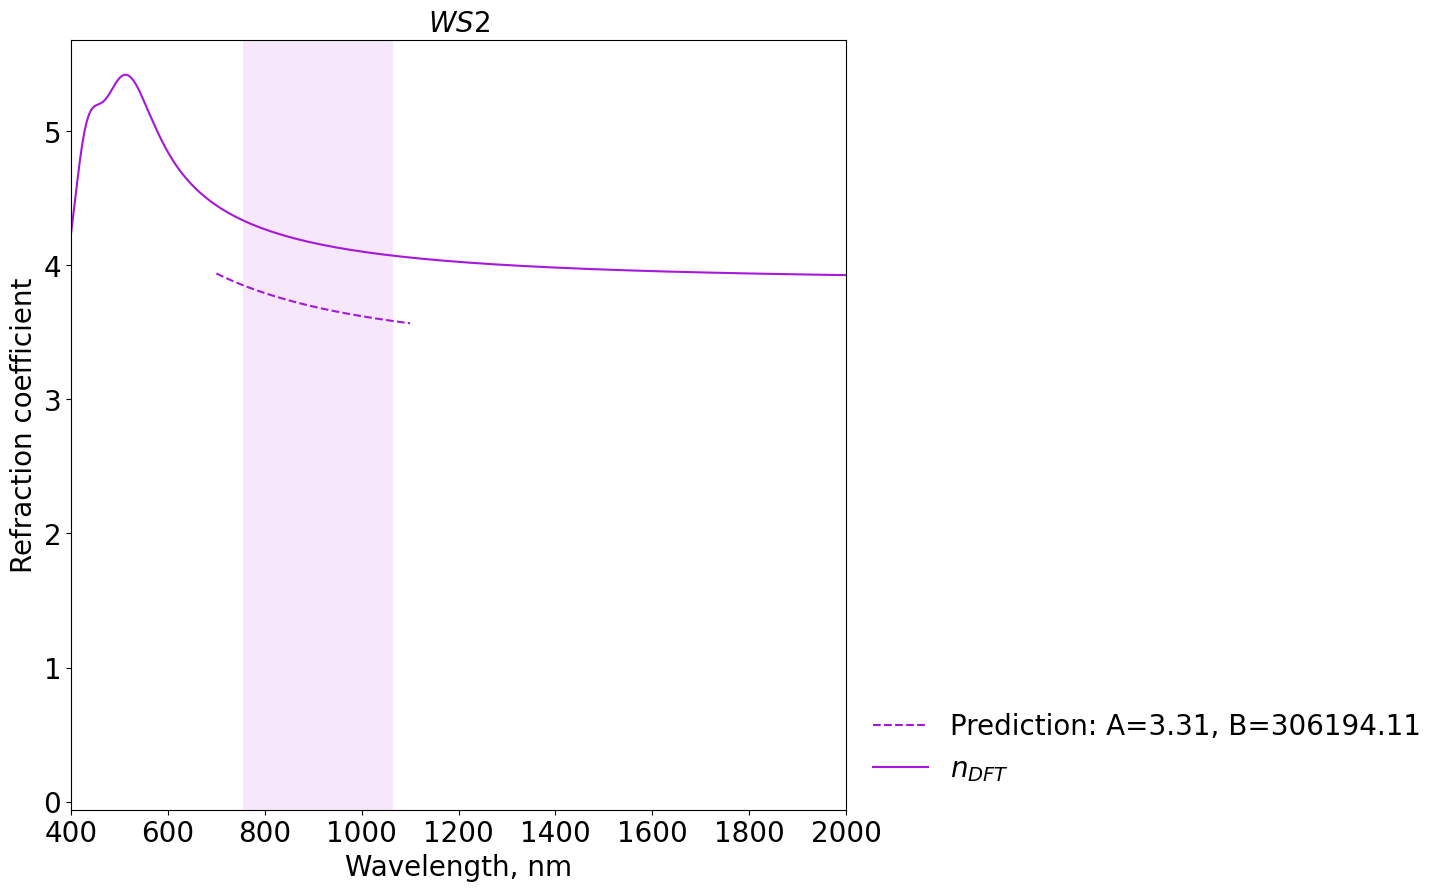

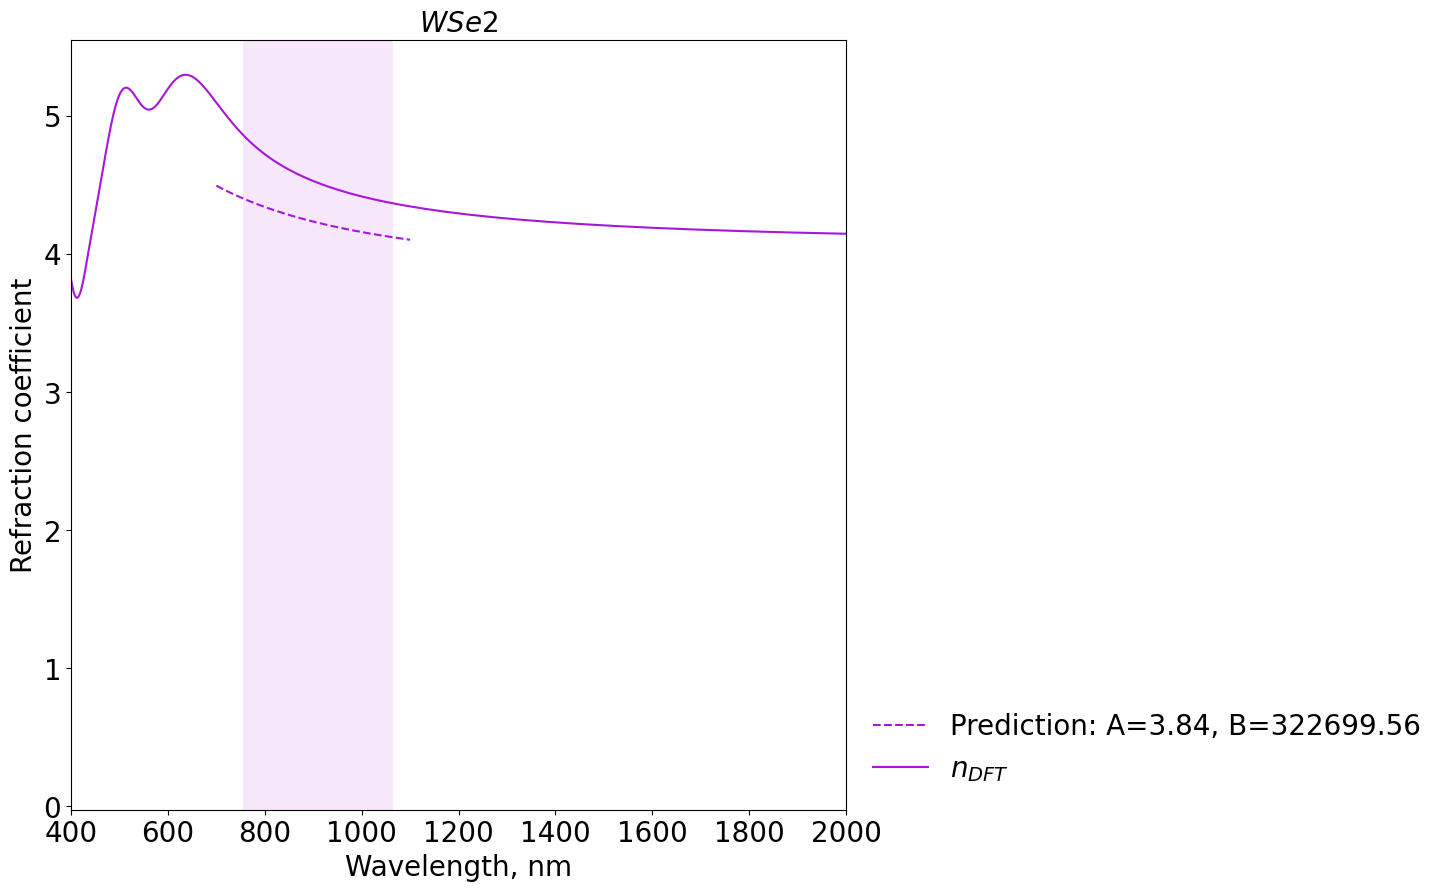

In [81]:
# Function for the refractive index
def n_wavelength(wavelength, A, B):
    return A + B / wavelength**2 + 1 / wavelength**4

dataframes_dict = {} 
wavelength_range = np.linspace(700, 1100, 500)


for j, dir_name in enumerate(df['directory'].to_numpy()):
    #os.chdir(os.path.join(base_path, dir_name))
    SYSTEM = str(dir_name)
    analyzer = OpticsAnalyzer(system=SYSTEM)
    THICKNESS_2D = df['lattice_c'][j]
    THICKNESS_3D = df['thickness_2D'][j]
    vasprun_dft = f'../data/{SYSTEM}/vasprun.xml'

    analyzer.read(vasprun_dft, thickness_2d = THICKNESS_2D, thickness_3d = THICKNESS_3D)
    dft_data = convert_epsilon_to_refractive_index(analyzer.data[0])
    plt.figure(figsize=(10, 10))

    data = dft_data
    method = data.method
    line = '-'
    line_k = '--'
    plt.axvspan(755, 1064, facecolor='#A717DB', alpha=0.1)
    # Coefficients A and B
    A = df['Ax_final'][j]
    B = df['Bx_final'][j] 

# Plot each curve

    n_values = n_wavelength(wavelength_range, A, B) 

    plt.plot(wavelength_range, n_values, linestyle='--', alpha=1.0, color='#A717DB', label=f'Prediction: A={A:.2f}, B={B:.2f}')

    plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, color = '#A717DB', label='$n_{DFT}$')



    plt.xlabel('Wavelength, nm', fontsize=20)
    plt.ylabel('Refraction coefficient', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(loc=(1.02, 0.02), edgecolor='white', fontsize=20)
    delta_n_value = data.real[data.real['Wavelength, nm'].between(1050, 1100)].iloc[0]
  
    plt.title(f'${SYSTEM}$', fontsize=20)
   
    plt.xlim(400,2000)
    plt.show()
    